CIFAR-10 Improved model

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from torch.utils.data import random_split, DataLoader
from torchmetrics import Recall, Precision, Accuracy
import copy

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [21]:

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),   
    transforms.RandomHorizontalFlip(),      
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010)) 
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010))
])

In [22]:
dataset_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(dataset_full))  
val_size = len(dataset_full) - train_size  
train_data, val_data = random_split(dataset_full, [train_size, val_size])

batch_size = 64  
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader   = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_dataloader  = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
images, labels=next(iter(train_dataloader))

Files already downloaded and verified
Files already downloaded and verified


In [23]:
class Net(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),               
            nn.Linear(128 * 4 * 4, num_classes)
        )

    def forward(self, x):
        x=self.feature_extractor(x)
        x=self.classifier(x)
        return(x)

In [24]:
net = Net(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)

# --- Metrics and Best Model ---
train_losses, val_losses, val_accuracies = [], [], []
best_model_wts = copy.deepcopy(net.state_dict())
best_val_loss = float('inf')

num_epochs = 20

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_dataloader)

    net.eval()
    val_loss = 0.0
    metric_acc = Accuracy(task="multiclass", num_classes=10).to(device)

    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            metric_acc.update(preds, labels)

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = metric_acc.compute().item() * 100

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Acc: {val_accuracy:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = copy.deepcopy(net.state_dict())
        torch.save(net.state_dict(), "best_model.pth")
        print("Model saved.")

net.load_state_dict(best_model_wts)

Epoch [1/20] Train Loss: 1.6301, Val Loss: 1.3019, Val Acc: 53.15%
Model saved.
Epoch [2/20] Train Loss: 1.2591, Val Loss: 1.0788, Val Acc: 61.89%
Model saved.
Epoch [3/20] Train Loss: 1.1096, Val Loss: 1.0048, Val Acc: 64.70%
Model saved.
Epoch [4/20] Train Loss: 1.0185, Val Loss: 0.9086, Val Acc: 68.26%
Model saved.
Epoch [5/20] Train Loss: 0.9574, Val Loss: 0.8874, Val Acc: 69.20%
Model saved.
Epoch [6/20] Train Loss: 0.9128, Val Loss: 0.9161, Val Acc: 68.21%
Epoch [7/20] Train Loss: 0.8762, Val Loss: 0.8345, Val Acc: 71.13%
Model saved.
Epoch [8/20] Train Loss: 0.8481, Val Loss: 0.7716, Val Acc: 72.94%
Model saved.
Epoch [9/20] Train Loss: 0.8222, Val Loss: 0.7339, Val Acc: 74.60%
Model saved.
Epoch [10/20] Train Loss: 0.7986, Val Loss: 0.7586, Val Acc: 73.56%
Epoch [11/20] Train Loss: 0.7862, Val Loss: 0.7252, Val Acc: 74.42%
Model saved.
Epoch [12/20] Train Loss: 0.7648, Val Loss: 0.7045, Val Acc: 75.82%
Model saved.
Epoch [13/20] Train Loss: 0.7533, Val Loss: 0.7045, Val Acc: 75

<All keys matched successfully>

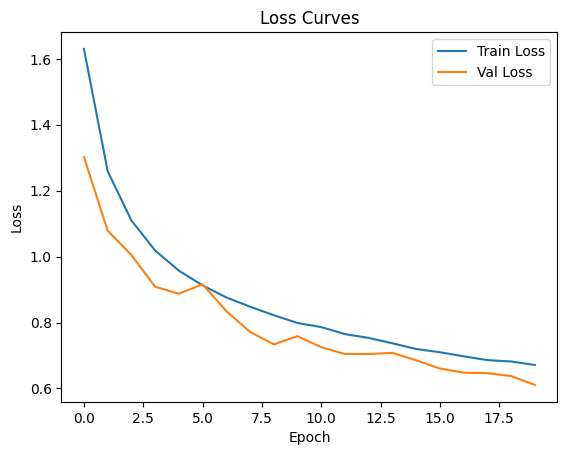

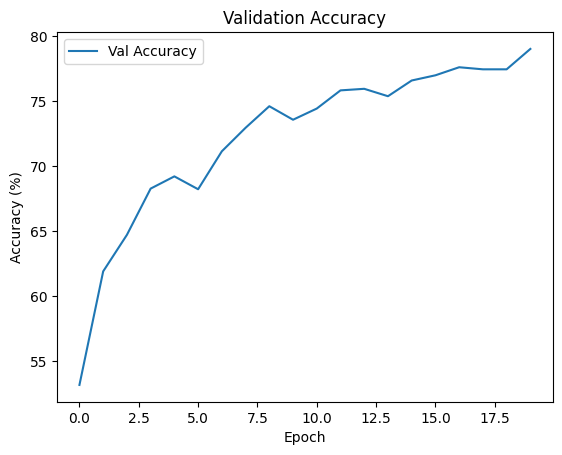

In [25]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

plt.figure()
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Validation Accuracy")
plt.show()

In [26]:
metric_acc = Accuracy(task='multiclass', num_classes=10, average='micro').to(device)
metric_precision = Precision(task='multiclass', num_classes=10, average='macro').to(device)
metric_recall = Recall(task='multiclass', num_classes=10, average='macro').to(device)


metric_precision.reset()
metric_recall.reset()
metric_acc.reset()


all_labels = []
all_preds = []

net.eval()
with torch.no_grad():
    for images, labels in tqdm(test_dataloader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)
        output = net(images)
        preds = torch.argmax(output, dim=1)

        metric_acc.update(preds, labels)
        metric_precision.update(preds, labels)
        metric_recall.update(preds, labels)

        all_labels.append(labels.cpu())
        all_preds.append(preds.cpu())

all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)

precision = metric_precision.compute().item()
recall = metric_recall.compute().item()
accuracy = metric_acc.compute().item()

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(all_labels, all_preds)
print(classification_report(all_labels, all_preds))



Evaluating: 100%|██████████| 157/157 [00:09<00:00, 16.21it/s]

Precision: 0.7950
Recall: 0.7959
Accuracy: 0.7959
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1000
           1       0.88      0.92      0.90      1000
           2       0.71      0.70      0.70      1000
           3       0.65      0.62      0.64      1000
           4       0.81      0.74      0.77      1000
           5       0.71      0.75      0.73      1000
           6       0.83      0.85      0.84      1000
           7       0.83      0.84      0.84      1000
           8       0.87      0.87      0.87      1000
           9       0.86      0.87      0.86      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



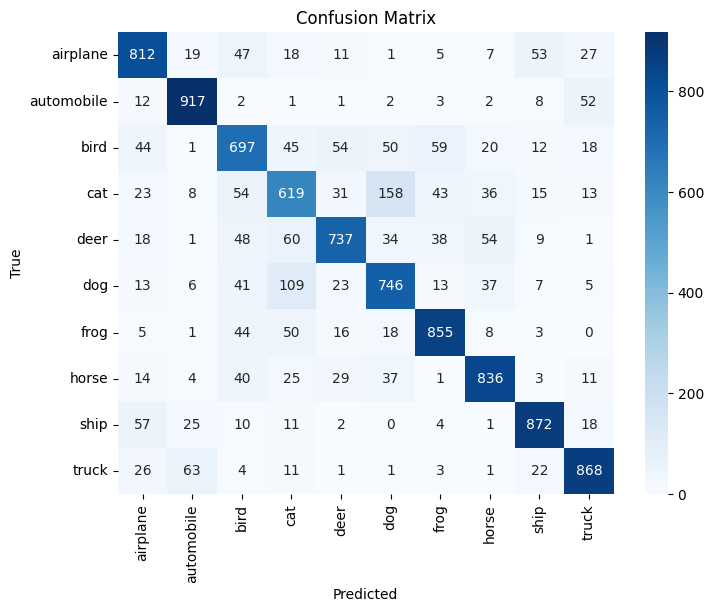

In [27]:
class_names = test_data.classes
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

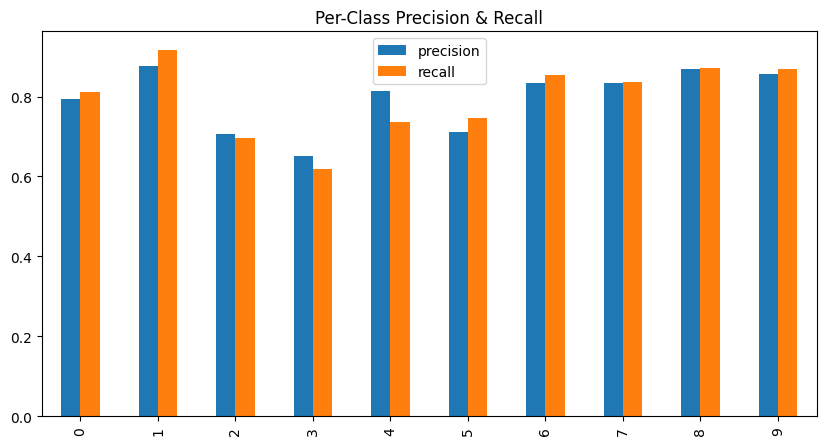

In [28]:
report = classification_report(all_labels, all_preds, output_dict=True)
df = pd.DataFrame(report).transpose()
df[:-3][['precision', 'recall']].plot(kind='bar', figsize=(10,5))
plt.title('Per-Class Precision & Recall')
plt.show()